In [82]:
import os
import sys
import torch
import transformers
import tqdm
import random
import json
import matplotlib.pyplot as plt
import scipy
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, GPTNeoXTokenizerFast, GPTNeoXForCausalLM

In [2]:
class Surprisal:
    def __init__(self, model_name):
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.model = AutoModel.from_pretrained(model_name, output_hidden_states=True)

        self.model.eval()

    def evaluate(sent):
        token_ids = self.tokenizer.encode(sent)
        
        with torch.no_grad():
            output = model(token_ids)
        softmax = torch.nn.Softmax(dim=-1) 
        return softmax(output.logits).squeeze(0)

In [36]:
def generate_stories(language):
    stories = []
    for a, b, c in os.walk('ud-215/ud-treebanks-v2.15'):
        if language in a:
            for f in c:
                if any(map(lambda i: f.endswith(i), ['dev.txt', 'test.txt', 'train.txt'])):
                    stories.extend(open(f'{a}/{f}').read().split("\n\n"))
    return stories

In [30]:
AutoTokenizer.from_pretrained("surajp/gpt2-hindi")

tokenizer_config.json:   0%|          | 0.00/87.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/597 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.09M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

GPT2TokenizerFast(name_or_path='surajp/gpt2-hindi', vocab_size=50257, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	50257: AddedToken("<|endoftext|>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
}
)

In [112]:
def calculate_surprisal(model_variant, mode, language):
    stories = generate_stories(language)
    tokenizer = AutoTokenizer.from_pretrained(model_variant)
    model = AutoModelForCausalLM.from_pretrained(model_variant)

    model.eval()
    softmax = torch.nn.Softmax(dim=-1)
    ctx_size = model.config.max_position_embeddings
    bos_id = model.config.bos_token_id

    batches = []
    words = []
    for story in tqdm.tqdm(stories):#, position=1):
        words.extend(story.split(" "))
        tokenizer_output = tokenizer(story)
        ids = tokenizer_output.input_ids
        attn = tokenizer_output.attention_mask

        # these tokenizers do not append bos_id by default
        if "gpt" in model_variant or "pythia" in model_variant:
            ids = [bos_id] + ids
            attn = [1] + attn

        start_idx = 0

        # sliding windows with 50% overlap
        # start_idx is for correctly indexing the "later 50%" of sliding windows
        while len(ids) > ctx_size:
            # for models that explicitly require the first dimension (batch_size)
            if "gpt-neox" in model_variant or "pythia" in model_variant or "opt" in model_variant:
                batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:ctx_size]).unsqueeze(0),
                                                            "attention_mask": torch.tensor(attn[:ctx_size]).unsqueeze(0)}),
                                torch.tensor(ids[1:ctx_size+1]), start_idx, True))
            # for other models
            elif "gpt" in model_variant:
                batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:ctx_size]),
                                                            "attention_mask": torch.tensor(attn[:ctx_size])}),
                                torch.tensor(ids[1:ctx_size+1]), start_idx, True))

            ids = ids[int(ctx_size/2):]
            attn = attn[int(ctx_size/2):]
            start_idx = int(ctx_size/2)

        # remaining tokens
        if "gpt-neox" in model_variant or "pythia" in model_variant or "opt" in model_variant:
            batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:-1]).unsqueeze(0),
                                                        "attention_mask": torch.tensor(attn[:-1]).unsqueeze(0)}),
                           torch.tensor(ids[1:]), start_idx, False))
        elif "gpt" in model_variant:
            batches.append((transformers.BatchEncoding({"input_ids": torch.tensor(ids[:-1]),
                                                        "attention_mask": torch.tensor(attn[:-1])}),
                           torch.tensor(ids[1:]), start_idx, False))

    print("word llmsurp")
    curr_word_surp = []
    curr_toks = []
    curr_word_ix = 0
    is_continued = False
    count = 0
    total = 0
    for batch in tqdm.tqdm(random.sample(batches, min(1000, len(batches)))):#, position=1):
        print("reading", batch)
        batch_input, output_ids, start_idx, will_continue = batch

        with torch.no_grad():
            model_output = model(**batch_input)

        toks = tokenizer.convert_ids_to_tokens(output_ids)
        index = torch.arange(0, output_ids.shape[0])
        surp = -1 * torch.log2(softmax(model_output.logits).squeeze(0)[index, output_ids])

        if mode == "token":
            # token-level surprisal
            for i in range(start_idx, len(toks)):
                cleaned_tok = tokenizer.convert_tokens_to_string([toks[i]]).replace(" ", "")
                # print(cleaned_tok, surp[i].item())
                total += surp[i].item()
                count += 1
                # print(count, total)

        elif mode == "word":
            # word-level surprisal
            # if the batch starts a new story
            if not is_continued:
                curr_word_surp = []
                curr_toks = []
            for i in range(start_idx, len(toks)):
                curr_word_surp.append(surp[i].item())
                curr_toks += [toks[i]]
                curr_toks_str = tokenizer.convert_tokens_to_string(curr_toks)
                # summing token-level surprisal
                # print(words[curr_word_ix], curr_toks_str.strip())
                if words[curr_word_ix] == curr_toks_str.strip():
                    # print(curr_toks_str.strip(), sum(curr_word_surp))
                    count += 1
                    total += sum(curr_word_surp)
                    curr_word_surp = []
                    curr_toks = []
                    curr_word_ix += 1
                    # print(count, total)

        is_continued = will_continue

        del model_output
    # print(count, total)
    return total / count

# calculate_surprisal("surajp/gpt2-hindi", "token", "Hindi")
    

In [109]:
surprisals

{'Arabic': 4.04563453238125,
 'Basque': 11.776336400187533,
 'Catalan': 9.052308156371192,
 'Croatian': 10.880824251416206,
 'Danish': 6.005561456922288,
 'Dutch': 8.102134119309605,
 'English': 5.385080123613887,
 'French': 11.2084986283827,
 'German': 9.493257881042421,
 'Hindi': 5.446858579018244,
 'Indonesian': 9.125195615680122,
 'Irish': 9.57934247551619,
 'Italian': 6.43303417319251,
 'Korean': 6.814609626414776,
 'Persian': 6.451482465428169,
 'Portuguese': 6.349698236746741,
 'Russian': 4.862853204450294,
 'Slovenian': 9.071584160015092,
 'Spanish': 7.127142944834537,
 'Turkish': 10.056914489134401,
 'Japanese': (0.9233324548842191, 1.825211022554627)}

In [113]:
models = {i.split(":")[0]: i.split(":")[1] for i in open("models.txt").read().split("\n")[:-1]}

for lang, model in tqdm.tqdm(list(models.items())):
    if lang in surprisals:
        print("skipping", lang)
        continue
    print("starting", lang)
    # try:
    # word_surprisal = calculate_surprisal(model, "word", lang)
    token_surprisal = calculate_surprisal(model, "token", lang)
    surprisals[lang] = (word_surprisal, token_surprisal)

    with open(f"surprisals-3-{lang}.txt", "w") as f:
        # f.write(f"Word: {word_surprisal}\n")
        f.write(f"Token: {token_surprisal}\n")

    print("finished", lang)
    # except Exception as e:
    #     print("ERROR ON LANG", lang)
    #     print(e)

  0%|                                                    | 0/36 [00:00<?, ?it/s]

skipping Arabic
skipping Basque
starting Belarusian



100%|████████████████████████████████████| 8392/8392 [00:00<00:00, 10659.11it/s]


word llmsurp



0it [00:00, ?it/s]
  6%|██▍                                         | 2/36 [00:01<00:21,  1.61it/s]


ZeroDivisionError: division by zero

In [70]:
flex_data = json.load(open("flexibility_ any.json", "r"))

In [71]:
flex_data

[{'label': ['Afrikaans/Indo-European-Germanic'],
  'data': [{'x': 0, 'y': 25.3, 'z': 0, 'r': 5, 'label': 'Afrikaans'}]},
 {'label': ['Akkadian/Semitic'],
  'data': [{'x': 0, 'y': 5.05, 'z': 0, 'r': 5, 'label': 'Akkadian'}]},
 {'label': ['Gheg/Indo-European'],
  'data': [{'x': 0, 'y': 20.67, 'z': 0, 'r': 5, 'label': 'Gheg'}]},
 {'label': ['Amharic/Afroasiatic'],
  'data': [{'x': 0, 'y': 21.45, 'z': 0, 'r': 5, 'label': 'Amharic'}]},
 {'label': ['Akuntsu/Tupian'],
  'data': [{'x': 0, 'y': 30.54, 'z': 0, 'r': 5, 'label': 'Akuntsu'}]},
 {'label': ['Arabic/Semitic'],
  'data': [{'x': 0, 'y': 9.03, 'z': 0, 'r': 5, 'label': 'Arabic'}]},
 {'label': ['Karo/Tupian'],
  'data': [{'x': 0, 'y': 16.65, 'z': 0, 'r': 5, 'label': 'Karo'}]},
 {'label': ['Belarusian/Indo-European-Baltoslavic'],
  'data': [{'x': 0, 'y': 25.78, 'z': 0, 'r': 5, 'label': 'Belarusian'}]},
 {'label': ['Beja/Afroasiatic'],
  'data': [{'x': 0, 'y': 31.12, 'z': 0, 'r': 5, 'label': 'Beja'}]},
 {'label': ['Bulgarian/Indo-European-Ba

In [72]:
flexibility = {i['data'][0]['label']: i['data'][0]['y'] for i in flex_data}

In [85]:
groups = {i['data'][0]['label']: i['label'][0].split("/")[1] for i in flex_data}
groups

{'Afrikaans': 'Indo-European-Germanic',
 'Akkadian': 'Semitic',
 'Gheg': 'Indo-European',
 'Amharic': 'Afroasiatic',
 'Akuntsu': 'Tupian',
 'Arabic': 'Semitic',
 'Karo': 'Tupian',
 'Belarusian': 'Indo-European-Baltoslavic',
 'Beja': 'Afroasiatic',
 'Bulgarian': 'Indo-European-Baltoslavic',
 'Bhojpuri': 'Indo-European',
 'Bambara': 'Niger-Congo',
 'Breton': 'Indo-European',
 'Buryat': 'Agglutinating',
 'Catalan': 'Indo-European-Romance',
 'Cebuano': 'Austronesian',
 'Chukot': 'Agglutinating',
 'Coptic': 'Afroasiatic',
 'Czech': 'Indo-European-Baltoslavic',
 'OldChurchSlavonic': 'Indo-European-Baltoslavic',
 'Welsh': 'Indo-European',
 'Danish': 'Indo-European-Germanic',
 'German': 'Indo-European-Germanic',
 'Greek': 'Indo-European',
 'Emerillon': 'Tupian',
 'English': 'Indo-European-Germanic',
 'Spanish': 'Indo-European-Romance',
 'Yupik': 'Eskimo–Aleut',
 'Estonian': 'Agglutinating',
 'Basque': 'isolate',
 'Persian': 'Indo-European',
 'Finnish': 'Agglutinating',
 'Faroese': 'Indo-Europe

In [77]:
surprisals = {}
for k in models.keys():
    try:
        surprisals[k] = float(open(f'surprisals-3-{k}.txt').read().split()[1])
    except Exception as e:
        print(k, e)

Belarusian [Errno 2] No such file or directory: 'surprisals-3-Belarusian.txt'
Bulgarian [Errno 2] No such file or directory: 'surprisals-3-Bulgarian.txt'
Chinese [Errno 2] No such file or directory: 'surprisals-3-Chinese.txt'
Czech [Errno 2] No such file or directory: 'surprisals-3-Czech.txt'
Estonian [Errno 2] No such file or directory: 'surprisals-3-Estonian.txt'
Finnish [Errno 2] No such file or directory: 'surprisals-3-Finnish.txt'
Hebrew [Errno 2] No such file or directory: 'surprisals-3-Hebrew.txt'
Icelandic [Errno 2] No such file or directory: 'surprisals-3-Icelandic.txt'
Japanese [Errno 2] No such file or directory: 'surprisals-3-Japanese.txt'
Latin [Errno 2] No such file or directory: 'surprisals-3-Latin.txt'
Norwegian [Errno 2] No such file or directory: 'surprisals-3-Norwegian.txt'
Polish [Errno 2] No such file or directory: 'surprisals-3-Polish.txt'
Romanian [Errno 2] No such file or directory: 'surprisals-3-Romanian.txt'
Sanskrit [Errno 2] No such file or directory: 'surpr

Arabic 9.03 4.04563453238125
Basque 35.78 11.776336400187533
Catalan 13.72 9.052308156371192
Croatian 25.8 10.880824251416206
Danish 26.22 6.005561456922288
Dutch 31.73 8.102134119309605
English 13.16 5.385080123613887
French 14.09 11.2084986283827
German 32.94 9.493257881042421
Hindi 1.59 5.446858579018244
Indonesian 18.69 9.125195615680122
Irish 9.63 9.57934247551619
Italian 18.1 6.43303417319251
Korean 5.43 6.814609626414776
Persian 16.06 6.451482465428169
Portuguese 14.15 6.349698236746741
Russian 28.79 4.862853204450294
Slovenian 27.58 9.071584160015092
Spanish 16.61 7.127142944834537
Turkish 3.61 10.056914489134401


/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_99497/2910299237.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


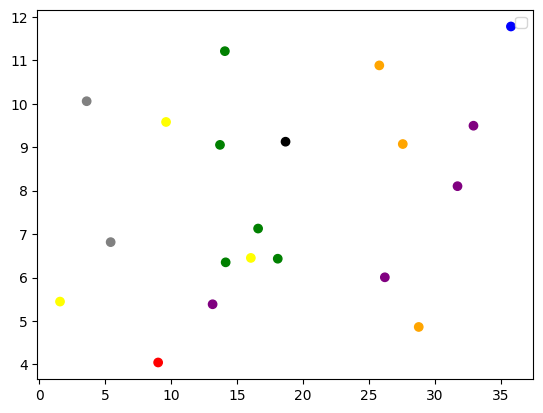

In [97]:
color_map = {
    'Semitic': 'red',
    'isolate': 'blue',
    'Indo-European-Romance': 'green',
    'Indo-European-Baltoslavic': 'orange',
    'Indo-European-Germanic': 'purple',
    'Indo-European': 'yellow',
    'Sino-Austronesian': 'black',
    'Agglutinating': 'gray'
}

xs = []
ys = []
cs = []
labels = []

for k in models.keys():
    if k in surprisals and k in flexibility:
        xs.append(flexibility[k])
        ys.append(surprisals[k])
        cs.append(color_map[groups[k]])
        labels.append(groups[k])
        print(k, xs[-1], ys[-1])

plt.scatter(xs, ys, color=cs)#, label=cs)
plt.legend()

In [83]:
scipy.stats.linregress(xs, ys)

LinregressResult(slope=0.06744395534459495, intercept=6.640287723851007, rvalue=0.29979643964875496, pvalue=0.19907746324273742, stderr=0.05058597645888903, intercept_stderr=1.0431591952684278)

In [100]:
def graph(flex_file, surp_k):
    flex_data = json.load(open(flex_file, "r"))
    flexibility = {i['data'][0]['label']: i['data'][0]['y'] for i in flex_data}
    groups = {i['data'][0]['label']: i['label'][0].split("/")[1] for i in flex_data}
    surprisals = {}
    for k in models.keys():
        try:
            surprisals[k] = float(open(f'surprisals-{surp_k}-{k}.txt').read().split()[1])
        except Exception as e:
            print(k, e)

    color_map = {
        'Semitic': 'red',
        'isolate': 'blue',
        'Indo-European-Romance': 'green',
        'Indo-European-Baltoslavic': 'orange',
        'Indo-European-Germanic': 'purple',
        'Indo-European': 'yellow',
        'Sino-Austronesian': 'black',
        'Agglutinating': 'gray'
    }
    
    xs = []
    ys = []
    cs = []
    labels = []
    
    for k in models.keys():
        if k in surprisals and k in flexibility:
            xs.append(flexibility[k])
            ys.append(surprisals[k])
            cs.append(color_map[groups[k]])
            labels.append(groups[k])
            print(k, xs[-1], ys[-1])
    
    plt.scatter(xs, ys, color=cs)#, label=cs)
    plt.legend()

    return scipy.stats.linregress(xs, ys)

Belarusian [Errno 2] No such file or directory: 'surprisals-3-Belarusian.txt'
Bulgarian [Errno 2] No such file or directory: 'surprisals-3-Bulgarian.txt'
Chinese [Errno 2] No such file or directory: 'surprisals-3-Chinese.txt'
Czech [Errno 2] No such file or directory: 'surprisals-3-Czech.txt'
Estonian [Errno 2] No such file or directory: 'surprisals-3-Estonian.txt'
Finnish [Errno 2] No such file or directory: 'surprisals-3-Finnish.txt'
Hebrew [Errno 2] No such file or directory: 'surprisals-3-Hebrew.txt'
Icelandic [Errno 2] No such file or directory: 'surprisals-3-Icelandic.txt'
Japanese [Errno 2] No such file or directory: 'surprisals-3-Japanese.txt'
Latin [Errno 2] No such file or directory: 'surprisals-3-Latin.txt'
Norwegian [Errno 2] No such file or directory: 'surprisals-3-Norwegian.txt'
Polish [Errno 2] No such file or directory: 'surprisals-3-Polish.txt'
Romanian [Errno 2] No such file or directory: 'surprisals-3-Romanian.txt'
Sanskrit [Errno 2] No such file or directory: 'surpr

/var/folders/my/xjpgt3ss01991yghb67xgjs80000gn/T/ipykernel_99497/3310615844.py:37: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


LinregressResult(slope=0.06744395534459495, intercept=6.640287723851007, rvalue=0.29979643964875496, pvalue=0.19907746324273742, stderr=0.05058597645888903, intercept_stderr=1.0431591952684278)

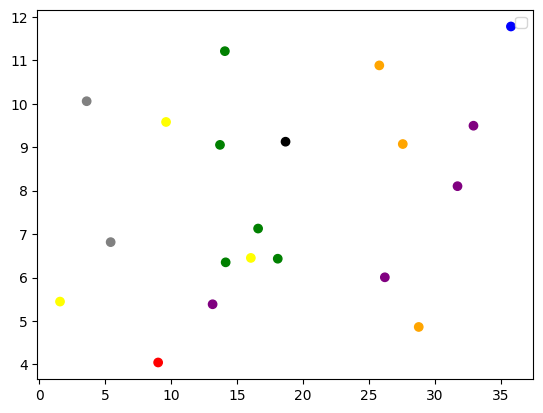

In [106]:
graph("flexibility_ any.json", 3)